# df scout project Balint Part 2: dealing with missing values

In [640]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [641]:
# load in the cleaned data 
df = pd.read_csv('data/clean_auto_scout.csv')

In [642]:
df.head()

,make_model,price,previous_owners_cleaned,co2emission_cleaned_gco2/km,emissionlabel_cleaned,emissionclass_cleaned,body_cleaned,bodycolor_cleaned,km_cleaned,vat_cleaned,...,led_headlights,lane_departure_warning_system,passenger-side_airbag,power_steering,rear_airbag,side_airbag,tire_pressure_monitoring_system,traction_control,traffic_sign_recognition,xenon_headlights
0,Audi A1,15770,2.0,99.0,NaN,6,Sedans,Black,56013.0,VAT deductible,...,0,0,1,1,0,1,1,1,0,1
1,Audi A1,14500,NaN,129.0,Green,6,Sedans,Red,80000.0,Price negotiable,...,0,0,1,1,0,1,1,1,0,1
2,Audi A1,14640,1.0,99.0,Green,6,Sedans,Black,83450.0,VAT deductible,...,0,0,1,1,0,1,1,1,0,0
3,Audi A1,14500,1.0,99.0,NaN,6,Sedans,Brown,73000.0,NaN,...,0,0,1,1,0,1,1,0,0,0
4,Audi A1,16790,1.0,109.0,NaN,6,Sedans,Black,16200.0,NaN,...,0,0,1,1,0,1,1,1,0,1


In [643]:
sorted(dict(df.isna().sum()))

['abs',
 'adaptive_cruise_control',
 'adaptive_headlights',
 'air_conditioning',
 'alarm_system',
 'alloy_wheels',
 'armrest',
 'automatic_climate_control',
 'blind_spot_monitor',
 'bluetooth',
 'body_cleaned',
 'bodycolor_cleaned',
 'catalytic_converter',
 'cd_player',
 'central_door_lock',
 'central_door_lock_with_remote_control',
 'co2emission_cleaned_gco2/km',
 'consumption_city_l_per_100km',
 'consumption_comb_l_per_100km',
 'consumption_country_l_per_100km',
 'countryversion_cleaned',
 'cruise_control',
 'cylinders_cleaned',
 'daytime_running_lights',
 'digital_radio',
 'displacement_cleaned_cc',
 'drivechain_cleaned',
 'driver-side_airbag',
 'driver_drowsiness_detection',
 'electric_tailgate',
 'electrical_side_mirrors',
 'electrically_adjustable_seats',
 'electrically_heated_windshield',
 'electronic_stability_control',
 'emergency_brake_assistant',
 'emergency_system',
 'emissionclass_cleaned',
 'emissionlabel_cleaned',
 'fog_lights',
 'fuel_cleaned',
 'gearingtype_cleaned',
 

## General strategy: find colinear variables and groupby these, calculate some average on the variable to fill 

## body_cleaned

In [644]:
df['body_cleaned'].value_counts(dropna = False)

body_cleaned
Sedans           7903
Station wagon    3553
Compact          3153
Van               783
Other             290
Transporter        88
NaN                60
Off-Road           56
Coupe              25
Convertible         8
Name: count, dtype: int64

In [645]:
# make_model probably most important grouping variable, use this to fill body
mode_body = df.groupby('make_model')['body_cleaned'].transform(lambda x: x.mode().iloc[0]) # Choose the first modal value of the group
df['body_cleaned_filled'] = df['body_cleaned'].fillna(mode_body)

## Registration cleaned - generate age column

In [646]:
# Extract year info to determine cars age
df['registration_cleaned'] = pd.to_datetime(df['registration_cleaned']) # convert to datetime type,looks like i did this already in part1, maybe converting to csv loses this
df['year'] = df['registration_cleaned'].dt.year
df['year'].value_counts(dropna = False)


year
2018.0    4522
2016.0    3674
2017.0    3273
2019.0    2853
NaN       1597
Name: count, dtype: int64

In [647]:
df.type_cleaned.value_counts(dropna= False)

type_cleaned
Used              11096
New                1650
Pre-registered     1364
Employee's car     1011
Demonstration       796
NaN                   2
Name: count, dtype: int64

In [648]:
# Fill 'new' cars as year 2019
df.loc[((df['type_cleaned'] == 'New') & df.year.isnull()), 'year'] = 2019 
df['year'].value_counts(dropna = False)


year
2018.0    4522
2019.0    4400
2016.0    3674
2017.0    3273
NaN         50
Name: count, dtype: int64

In [649]:
mean = df[(df['make_model'] == 'Audi A1') & (df['body_cleaned_filled'] == 'Compact')].groupby('year').km_cleaned.mean()
std = df[(df['make_model'] == 'Audi A1') & (df['body_cleaned_filled'] == 'Compact')].groupby('year').km_cleaned.std()
mean

year
2016.0    55367.337607
2017.0    23698.347826
2018.0    14558.460674
2019.0     2580.693878
Name: km_cleaned, dtype: float64

In [650]:
def year_fill(year,km,mean,std):
    if pd.isna(year):
        for i in range(len(mean.values)):
            if mean.index[i] == 2016:
                if km >= (mean.values[i]-(std.values[i])):
                    return 2016
            if mean.index[i] == 2017:
                if (km >= (mean.values[i]-std.values[i])) | (km <= (mean.values[i]+std.values[i])):
                    return 2017
            if mean.index[i] == 2018:
                if (km >= (mean.values[i]-std.values[i])) | (km <= (mean.values[i]+std.values[i])):
                    return 2018
            if mean.index[i] == 2019:
                if km <= (mean.values[i]+std.values[i]):
                    return 2019
    else:
        return year

In [651]:
for group1 in list(df['make_model'].unique()):
    for group2 in list(df['body_cleaned_filled'].unique()):
        cond1 = df['make_model'] == group1
        cond2 = df['body_cleaned_filled'] == group2
        mean = df[cond1 & cond2].groupby('year').km_cleaned.mean()
        std = df[cond1 & cond2].groupby('year').km_cleaned.std()
        df.loc[cond1 & cond2, 'year'] = (df[cond1 & cond2]
                                  .apply(lambda x: year_fill(x['year'],x['km_cleaned'],mean,std),axis=1))

In [652]:
def year_fill(year,price,mean,std):
    if pd.isna(year):
        for i in range(len(mean.values)):
            if mean.index[i] == 2019:
                if price >= (mean.values[i]-(std.values[i])):
                    return 2019
            if mean.index[i] == 2018:
                if (price >= (mean.values[i]-std.values[i])) | (price <= (mean.values[i]+std.values[i])):
                    return 2018
            if mean.index[i] == 2017:
                if (price >= (mean.values[i]-std.values[i])) | (price <= (mean.values[i]+std.values[i])):
                    return 2017
            if mean.index[i] == 2016:
                if price <= (mean.values[i]+std.values[i]):
                    return 2016
    else:
        return year

In [653]:
for group1 in list(df['make_model'].unique()):
    for group2 in list(df['body_cleaned_filled'].unique()):
        cond1 = df['make_model'] == group1
        cond2 = df['body_cleaned_filled'] == group2
        mean = df[cond1 & cond2].groupby('year').price.mean()
        std = df[cond1 & cond2].groupby('year').price.std()
        df.loc[cond1 & cond2, 'year'] = (df[cond1 & cond2]
                                  .apply(lambda x: year_fill(x['year'],x['price'],mean,std),axis=1))

In [654]:
df[df['year'].isna()][['km_cleaned', 'make_model']]

,km_cleaned,make_model


In [655]:
df['year'].value_counts(dropna=False)

year
2018.0    4522
2019.0    4400
2016.0    3683
2017.0    3314
Name: count, dtype: int64

In [656]:
# Generate 'age' column where 2019 is new (age = 0)
# Define the mapping of year to age
year_to_age = {
    2019: 0,
    2018: 1,
    2017: 2,
    2016: 3
}
# Use map() to apply the mapping
df['age_filled'] = df['year'].map(year_to_age)
df['age_filled'].value_counts(dropna = False)

age_filled
1    4522
0    4400
3    3683
2    3314
Name: count, dtype: int64

In [657]:
df.non_enc_cols = df[['make_model',
'previous_owners_cleaned',
 'co2emission_cleaned_gco2/km',
 'emissionlabel_cleaned',
 'emissionclass_cleaned',
 'body_cleaned',
 'bodycolor_cleaned',
 'km_cleaned',
 'vat_cleaned',
 'hp_kw_cleaned',
 'nextinspection_cleaned',
 'type_cleaned',
 'fuel_cleaned',
 'offernumber_cleaned',
 'warranty_months',
 'painttype_cleaned',
 'interior_material',
 'interior_colour',
 'nrofdoors_cleaned',
 'nrofseats_cleaned',
 'modelcode_cleaned',
 'gearingtype_cleaned',
 'gears_cleaned',
 'cylinders_cleaned',
 'drivechain_cleaned',
 'weight_cleaned_kg',
 'displacement_cleaned_cc',
 'countryversion_cleaned',
 'consumption_comb_l_per_100km',
 'consumption_city_l_per_100km',
 'consumption_country_l_per_100km']]

C:\Users\BalintStewart\AppData\Local\Temp\ipykernel_21424\1739414025.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.non_enc_cols = df[['make_model',


In [658]:
# Determine columns with missing values
cols_with_mv = df.columns[df.isna().sum() > 0]
print(sorted(cols_with_mv))

['body_cleaned', 'bodycolor_cleaned', 'co2emission_cleaned_gco2/km', 'consumption_city_l_per_100km', 'consumption_comb_l_per_100km', 'consumption_country_l_per_100km', 'countryversion_cleaned', 'cylinders_cleaned', 'displacement_cleaned_cc', 'drivechain_cleaned', 'emissionclass_cleaned', 'emissionlabel_cleaned', 'gears_cleaned', 'hp_kw_cleaned', 'inspectionnew_cleaned', 'interior_colour', 'interior_material', 'km_cleaned', 'modelcode_cleaned', 'nextinspection_cleaned', 'nrofdoors_cleaned', 'nrofseats_cleaned', 'offernumber_cleaned', 'painttype_cleaned', 'previous_owners_cleaned', 'registration_cleaned', 'type_cleaned', 'vat_cleaned', 'warranty_months', 'weight_cleaned_kg']


## Heatmap to look for some colinearlity patterns in the numerical variables 


<Axes: >

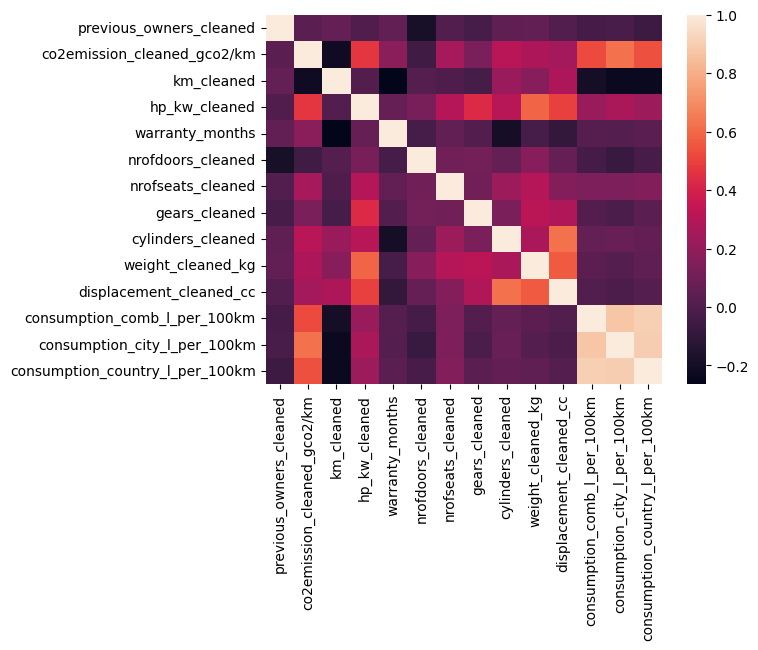

In [659]:
# Select only numeric columns
numeric_cols = df.non_enc_cols.select_dtypes(include=[np.number])

# Generate the correlation matrix for these numeric columns
corr_matrix = numeric_cols.corr()

# Pass the correlation matrix to sns.heatmap()
sns.heatmap(corr_matrix)
# heatmap of correlations for numeric cols (includes numeric categorical variables like age)

## Try to impute mvs for the cateegorical variables first, then can use these wi groupbys to calculate groped medians for filling the numeric variables

Question: is it a potential issue (e.g. compounding error) to use the filled versions as grouping variables for imputation of other columns??

## type_cleaned column 

In [660]:
df['type_cleaned'].isna().sum()

np.int64(2)

In [661]:
df['type_cleaned_filled'] = df['type_cleaned'].fillna(df['type_cleaned'].mode()[0]) 
df['type_cleaned_filled'].value_counts(dropna = False)

type_cleaned_filled
Used              11098
New                1650
Pre-registered     1364
Employee's car     1011
Demonstration       796
Name: count, dtype: int64

Only 2 missig values, fill with the mode of the column

## km_cleaned

In [662]:
median_group_km = df.groupby(['make_model','body_cleaned_filled','age_filled'])['km_cleaned'].transform(lambda x: x.median()) 

df['km_cleaned_filled'] = df['km_cleaned'].fillna(median_group_km)
df['km_cleaned_filled'].isna().sum()

c:\Users\BalintStewart\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\BalintStewart\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


np.int64(4)

In [663]:
# 4 missing values left, use just make_model and age_filled instead
leftover_median_group_km = df.groupby(['make_model','age_filled'])['km_cleaned'].transform(lambda x: x.median()) 

df['km_cleaned_filled'] = df['km_cleaned_filled'].fillna(leftover_median_group_km)
df['km_cleaned_filled'].isna().sum()

np.int64(0)

## previous_owners_cleaned

<Axes: xlabel='previous_owners_cleaned', ylabel='Count'>

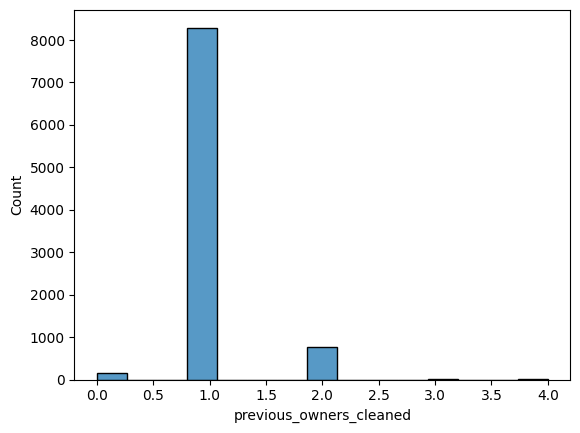

In [664]:
# Look at the distribution of values
sns.histplot(df['previous_owners_cleaned'])

Looks like nans might just be previous_owners = 0, 0s look underrepresented in the data

In [665]:
# compare distribution of nan and values in whether car is new or not
poc_nan = df[df['previous_owners_cleaned'].isna()]
poc_vals = df[~df['previous_owners_cleaned'].isna()]

In [666]:
poc_nan['type_cleaned_filled'].value_counts(dropna = False) # Nearly all the 'New' cars (1496 out of 1650) are in the nans.

type_cleaned_filled
Used              4012
New               1496
Pre-registered     519
Employee's car     356
Demonstration      282
Name: count, dtype: int64

In [667]:
poc_vals['type_cleaned_filled'].value_counts(dropna = False) 

type_cleaned_filled
Used              7086
Pre-registered     845
Employee's car     655
Demonstration      514
New                154
Name: count, dtype: int64

In [668]:
index=df[df["km_cleaned_filled"]<100].index
df.loc[(df['type_cleaned_filled'] == 'New') & (df['km_cleaned_filled']>3000),'type_cleaned_filled'] = 'Used'
df.loc[index,"previous_owners_cleaned"]=0.0
df.loc[(df["type_cleaned_filled"]=="New") & (df["previous_owners_cleaned"].isnull()),"previous_owners_cleaned"]=1.0
df.loc[((df["age_filled"]==0) | (df["km_cleaned_filled"]<5000)) & (df["previous_owners_cleaned"].isnull()),"previous_owners_cleaned"]=1.0
mode_group_po = df.groupby(['age_filled'])['previous_owners_cleaned'].transform(lambda x: x.mode()[0] if list(x.mode()) != [] else np.nan)
df["previous_owners_cleaned"].fillna(mode_group_po, inplace=True)
df['previous_owners_cleaned'].isnull().sum()



C:\Users\BalintStewart\AppData\Local\Temp\ipykernel_21424\3197488770.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["previous_owners_cleaned"].fillna(mode_group_po, inplace=True)


np.int64(0)

In [669]:
df['previous_owners_cleaned'].value_counts(dropna=False)

previous_owners_cleaned
1.0    12167
0.0     2963
2.0      770
3.0       17
4.0        2
Name: count, dtype: int64

In [670]:
# Change column name from previous_owners_cleaned to previous_owners_cleaned_filled
df['previous_owners_cleaned_filled'] = df['previous_owners_cleaned']

## co2_emission_cleaned

In [671]:
df['co2emission_cleaned_gco2/km'].value_counts()

co2emission_cleaned_gco2/km
120.0    740
99.0     545
97.0     537
104.0    501
102.0    477
103.0    445
114.0    382
124.0    372
108.0    362
107.0    362
119.0    361
106.0    349
128.0    329
126.0    282
85.0     275
118.0    270
110.0    266
127.0    257
117.0    254
111.0    237
113.0    235
109.0    234
139.0    224
140.0    218
129.0    213
105.0    202
135.0    202
92.0     198
130.0    180
123.0    178
150.0    174
112.0    171
143.0    171
95.0     161
116.0    157
141.0    156
98.0     151
136.0    145
133.0    145
137.0    133
125.0    132
134.0    130
145.0    126
149.0    117
153.0    113
147.0    109
101.0    105
132.0    100
115.0     86
122.0     83
121.0     82
138.0     75
93.0      66
168.0     58
142.0     58
148.0     48
131.0     48
154.0     40
144.0     40
94.0      37
146.0     36
100.0     36
90.0      35
151.0     34
91.0      31
186.0     30
152.0     28
187.0     26
172.0     25
82.0      25
96.0      22
89.0      19
189.0     19
157.0     18
158.0     

In [672]:
mode_co2 = df.groupby(['make_model', 'fuel_cleaned','displacement_cleaned_cc'])['co2emission_cleaned_gco2/km'].transform(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
df['co2emission_cleaned_filled'] = df['co2emission_cleaned_gco2/km'].fillna(mode_co2)

In [673]:
df['co2emission_cleaned_filled'].isna().sum()

np.int64(505)

In [674]:
# Have 505 leftover nas (no mode for that grouping), group by higher grouping and impute based on this. make_model probably most important, start with this
mode_co2_leftover = df.groupby(['make_model','displacement_cleaned_cc'])['co2emission_cleaned_gco2/km'].transform(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
df['co2emission_cleaned_filled'] = df['co2emission_cleaned_filled'].fillna(mode_co2_leftover)
df['co2emission_cleaned_filled'].isna().sum()

np.int64(486)

In [675]:
# Have 1 leftover nas (no median for that grouping), group by higher grouping and impute based on this. make_model probably most important, start with this
median_co2_leftover2 = df.groupby(['make_model'])['co2emission_cleaned_gco2/km'].transform(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
df['co2emission_cleaned_filled'] = df['co2emission_cleaned_filled'].fillna(median_co2_leftover2)
df['co2emission_cleaned_filled'].isna().sum()

np.int64(1)

In [676]:
# Have 1 leftover nas (no median for that grouping), group by higher grouping and impute based on this. make_model probably most important, start with this
median_co2_leftover3 = df.groupby(['fuel_cleaned'])['co2emission_cleaned_gco2/km'].transform(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
df['co2emission_cleaned_filled'] = df['co2emission_cleaned_filled'].fillna(median_co2_leftover3)
df['co2emission_cleaned_filled'].isna().sum()

np.int64(0)

## emission_class column

In [677]:
mode_emissionclass = df.groupby(['co2emission_cleaned_filled', 'fuel_cleaned'])['emissionclass_cleaned'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
df['emissionclass_cleaned_filled'] = df['emissionclass_cleaned'].fillna(mode_emissionclass)
df['emissionclass_cleaned_filled'].value_counts(dropna= False)

emissionclass_cleaned_filled
6      13391
6d      2232
6c       127
5         78
4         60
NaN       31
Name: count, dtype: int64

In [678]:
mode_emissionclass1 = df.groupby(['co2emission_cleaned_filled'])['emissionclass_cleaned'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
df['emissionclass_cleaned_filled'] = df['emissionclass_cleaned_filled'].fillna(mode_emissionclass1)
df['emissionclass_cleaned_filled'].value_counts(dropna= False)

emissionclass_cleaned_filled
6      13413
6d      2233
6c       127
5         78
4         60
NaN        8
Name: count, dtype: int64

In [679]:
mode_emissionclass2 = df.groupby(['fuel_cleaned'])['emissionclass_cleaned'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
df['emissionclass_cleaned_filled'] = df['emissionclass_cleaned_filled'].fillna(mode_emissionclass2)
df['emissionclass_cleaned_filled'].value_counts(dropna= False)

emissionclass_cleaned_filled
6     13421
6d     2233
6c      127
5        78
4        60
Name: count, dtype: int64

In [680]:
# Determine columns with missing values
cols_with_mv = df.columns[df.isna().sum() > 0]
print(sorted(cols_with_mv))

['body_cleaned', 'bodycolor_cleaned', 'co2emission_cleaned_gco2/km', 'consumption_city_l_per_100km', 'consumption_comb_l_per_100km', 'consumption_country_l_per_100km', 'countryversion_cleaned', 'cylinders_cleaned', 'displacement_cleaned_cc', 'drivechain_cleaned', 'emissionclass_cleaned', 'emissionlabel_cleaned', 'gears_cleaned', 'hp_kw_cleaned', 'inspectionnew_cleaned', 'interior_colour', 'interior_material', 'km_cleaned', 'modelcode_cleaned', 'nextinspection_cleaned', 'nrofdoors_cleaned', 'nrofseats_cleaned', 'offernumber_cleaned', 'painttype_cleaned', 'registration_cleaned', 'type_cleaned', 'vat_cleaned', 'warranty_months', 'weight_cleaned_kg']


## emissionlabel_cleaned

In [681]:
df[['emissionclass_cleaned_filled','emissionlabel_cleaned']].value_counts(dropna = False)

emissionclass_cleaned_filled  emissionlabel_cleaned
6                             NaN                      10540
                              Green                     2599
6d                            NaN                       1217
                              Green                      908
6                             No sticker                 273
6d                            No sticker                 106
6c                            NaN                         93
5                             NaN                         67
4                             NaN                         57
6c                            Green                       34
5                             Green                        9
6                             Blue                         8
4                             Green                        3
5                             No sticker                   2
6                             Yellow                       1
6d                            Red

In [682]:
# Lots of NAs here, suggest we drop
df.drop('emissionlabel_cleaned', axis = 1, inplace = True)

## bodycolor_cleaned

In [683]:
df['bodycolor_cleaned'].value_counts(dropna = False)

bodycolor_cleaned
Black     3745
Grey      3505
White     3406
Silver    1647
Blue      1431
Red        957
NaN        597
Brown      289
Green      154
Beige      108
Yellow      51
Violet      18
Bronze       6
Orange       3
Gold         2
Name: count, dtype: int64

In [684]:
mode_bodycolor = df.groupby(['make_model','body_cleaned_filled'])['bodycolor_cleaned'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
df['bodycolor_cleaned_filled'] = df['bodycolor_cleaned'].fillna(mode_bodycolor)
df['bodycolor_cleaned_filled'].value_counts(dropna = False)

bodycolor_cleaned_filled
Black     3941
Grey      3836
White     3469
Silver    1647
Blue      1431
Red        957
Brown      289
Green      158
Beige      108
Yellow      51
Violet      18
Bronze       6
Orange       3
NaN          3
Gold         2
Name: count, dtype: int64

In [685]:
# groupby make_model only now
mode_bodycolor2 = df.groupby(['make_model'])['bodycolor_cleaned'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
df['bodycolor_cleaned_filled'] = df['bodycolor_cleaned_filled'].fillna(mode_bodycolor2)
df['bodycolor_cleaned_filled'].value_counts(dropna = False)

bodycolor_cleaned_filled
Black     3941
Grey      3839
White     3469
Silver    1647
Blue      1431
Red        957
Brown      289
Green      158
Beige      108
Yellow      51
Violet      18
Bronze       6
Orange       3
Gold         2
Name: count, dtype: int64

## painttype_cleaned

In [686]:
df['painttype_cleaned'].value_counts(dropna = False)

painttype_cleaned
Metallic       9794
NaN            5772
Uni/basic       347
Perl effect       6
Name: count, dtype: int64

In [687]:
mode_painttype = df.groupby(['make_model','bodycolor_cleaned_filled'])['painttype_cleaned'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
df['painttype_cleaned_filled'] = df['painttype_cleaned'].fillna(mode_painttype)
df['painttype_cleaned_filled'].value_counts(dropna = False)

painttype_cleaned_filled
Metallic       15536
Uni/basic        364
NaN               11
Perl effect        8
Name: count, dtype: int64

In [688]:
# groupby make_model only now to impute the remaining 11 missing values
mode_painttype2 = df.groupby(['make_model'])['painttype_cleaned'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
df['painttype_cleaned_filled'] = df['painttype_cleaned_filled'].fillna(mode_painttype2)
df['painttype_cleaned_filled'].value_counts(dropna = False)

painttype_cleaned_filled
Metallic       15547
Uni/basic        364
Perl effect        8
Name: count, dtype: int64

In [689]:
# compare value counts of body and make_model
df[['body_cleaned_filled','make_model']].value_counts(dropna= False)

body_cleaned_filled  make_model    
Sedans               Audi A3           2605
Station wagon        Opel Insignia     1614
Sedans               Audi A1           1538
Compact              Opel Corsa        1232
Station wagon        Opel Astra        1218
Sedans               Opel Astra        1053
Compact              Audi A1           1039
Sedans               Renault Clio       933
                     Opel Insignia      900
                     Opel Corsa         875
Van                  Renault Espace     803
Compact              Renault Clio       484
Station wagon        Renault Clio       337
                     Audi A3            282
Compact              Opel Astra         185
                     Audi A3            182
Station wagon        Renault Espace      91
Other                Opel Corsa          87
                     Opel Astra          67
Transporter          Renault Espace      52
Other                Renault Clio        51
                     Opel Insignia      

## nr of seats cleaned

In [690]:
mode_nrofseats = df.groupby(['make_model','body_cleaned_filled'])['nrofseats_cleaned'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
df['nrofseats_cleaned_filled'] = df['nrofseats_cleaned'].fillna(mode_nrofseats)
df['nrofseats_cleaned_filled'].value_counts(dropna = False)

nrofseats_cleaned_filled
5.0    14302
4.0     1127
7.0      362
2.0      119
NaN        6
6.0        2
3.0        1
Name: count, dtype: int64

In [691]:
# groupby make_model only now to impute the remaining 6 missing values
mode_nrofseats2 = df.groupby(['make_model'])['nrofseats_cleaned'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
df['nrofseats_cleaned_filled'] = df['nrofseats_cleaned_filled'].fillna(mode_nrofseats2)
df['nrofseats_cleaned_filled'].value_counts(dropna = False)

nrofseats_cleaned_filled
5.0    14308
4.0     1127
7.0      362
2.0      119
6.0        2
3.0        1
Name: count, dtype: int64

## nrofdoors_cleaned

In [692]:
mode_nrofdoors = df.groupby(['make_model','body_cleaned_filled'])['nrofdoors_cleaned'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
df['nrofdoors_cleaned_filled'] = df['nrofdoors_cleaned'].fillna(mode_nrofdoors)
df['nrofdoors_cleaned_filled'].value_counts(dropna = False)

nrofdoors_cleaned_filled
5.0    11785
4.0     3079
3.0      832
2.0      219
NaN        2
1.0        1
7.0        1
Name: count, dtype: int64

In [693]:
# groupby make_model only now to impute the remaining 2 missing values
mode_nrofdoors2 = df.groupby(['make_model'])['nrofdoors_cleaned'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
df['nrofdoors_cleaned_filled'] = df['nrofdoors_cleaned_filled'].fillna(mode_nrofdoors2)
df['nrofdoors_cleaned_filled'].value_counts(dropna = False)

nrofdoors_cleaned_filled
5.0    11787
4.0     3079
3.0      832
2.0      219
1.0        1
7.0        1
Name: count, dtype: int64

## countryversion_cleaned

In [694]:
pd.set_option('display.max_rows', 100)
df[['make_model','countryversion_cleaned']].value_counts(dropna = False)

make_model      countryversion_cleaned
Audi A3         NaN                       1880
Audi A1         NaN                       1400
Opel Astra      NaN                       1297
Opel Insignia   NaN                       1204
Opel Corsa      NaN                       1017
Renault Clio    NaN                        990
Opel Insignia   Germany                    974
Opel Astra      Germany                    840
Opel Corsa      Germany                    840
Audi A1         Germany                    767
Renault Espace  NaN                        520
Renault Clio    Germany                    457
Audi A3         Germany                    379
                Italy                      353
Renault Espace  Germany                    244
Audi A3         European Union             219
Opel Corsa      Italy                      176
Audi A1         Italy                      156
Opel Insignia   Netherlands                141
Renault Clio    Italy                      125
Opel Astra      Italy

Doesn't look like make_model is an especially good predictor (e.g. Audi A3 equally likely to be Germany or Italy), can we impute 'unknown_country' to replace nan as its own category? Or else drop this feature...

In [695]:
df['countryversion_cleaned_filled'] = df['countryversion_cleaned'].fillna('Unknown_country')
df['countryversion_cleaned_filled'].value_counts(dropna = False)

countryversion_cleaned_filled
Unknown_country    8333
Germany            4502
Italy              1038
European Union      507
Netherlands         464
Spain               325
Belgium             314
Austria             208
Czech Republic       52
Poland               49
France               38
Denmark              33
Hungary              28
Japan                 8
Croatia               4
Slovakia              4
Sweden                3
Bulgaria              2
Romania               2
Switzerland           1
Luxembourg            1
Slovenia              1
Serbia                1
Egypt                 1
Name: count, dtype: int64

In [696]:
pd.set_option('display.max_rows', None)
df['modelcode_cleaned'].value_counts(dropna = False)

modelcode_cleaned
NaN         10941
0035/BCB      268
0588/BNO      245
0588/BDB      206
0588/BHX      188
1844/ADJ      175
0588/BDF      175
0588/BCV      139
3333/BAJ      122
3333/BEF      118
0588/AYB      117
0035/BEL      111
0588/BLL      109
3333/BHJ       87
0588/BLH       86
0035/BFM       84
0035/BKN       84
0588/AWJ       82
3333/BJR       79
0588/BHM       79
0035/BFI       76
0035/BKQ       69
0588/BDC       67
0035/BKU       62
0035/BHM       60
0035/BBZ       59
3333/BDQ       59
0588/BNN       58
0588/BLG       53
0588/BDG       52
3333/BEG       50
0035/BHQ       48
0035/BCJ       46
0035/BFP       44
1844/AJG       43
0035/BHP       43
0035/BHY       41
0588/BHL       40
0035/BFJ       39
0035/BCL       38
0588/BCZ       35
0588/BIB       35
1844/ACW       35
0035/BGP       35
1844/ACP       32
1844/AAI       32
0588/BCW       31
1844/AAK       30
0035/BKM       29
0035/BBU       28
0035/BKY       27
0035/BHZ       26
1844/AEV       24
0035/BKR       23
3333/BAU  

In [697]:
pd.set_option('display.max_rows', None)
df[['make_model','modelcode_cleaned']].value_counts(dropna = False)

make_model      modelcode_cleaned
Audi A3         NaN                  2293
Opel Insignia   NaN                  1813
Opel Astra      NaN                  1749
Opel Corsa      NaN                  1463
Audi A1         NaN                  1434
Renault Clio    NaN                  1385
Renault Espace  NaN                   770
Opel Corsa      0035/BCB              268
Audi A1         0588/BNO              245
                0588/BDB              206
Audi A3         0588/BHX              188
Audi A1         0588/BDF              175
Opel Corsa      1844/ADJ              175
Audi A1         0588/BCV              139
Renault Clio    3333/BAJ              122
                3333/BEF              118
Audi A3         0588/AYB              117
Opel Insignia   0035/BEL              111
Audi A3         0588/BLL              109
Renault Espace  3333/BHJ               87
Audi A3         0588/BLH               86
Opel Astra      0035/BFM               84
Audi A3         0588/AWJ               82


Seems like modelcode isn't a very useful feature here, lots of missing values difficult to impute on information we already have. Suggest we drop entirely

In [698]:
df.drop('modelcode_cleaned', axis = 1, inplace = True)

## vat_cleaned column

In [699]:
df['vat_cleaned'].value_counts(dropna = False)

vat_cleaned
VAT deductible      10980
NaN                  4513
Price negotiable      426
Name: count, dtype: int64

In this case, nan refers to 'VAT nondeductible'. Replace with this 

In [700]:
df['vat_cleaned_filled'] = df['vat_cleaned'].fillna('VAT nondeductible')
df['vat_cleaned_filled'].value_counts(dropna = False)

vat_cleaned_filled
VAT deductible       10980
VAT nondeductible     4513
Price negotiable       426
Name: count, dtype: int64

## gears_cleaned

In [701]:
df['gears_cleaned'].value_counts(dropna= False)

gears_cleaned
6.0     5822
NaN     4712
5.0     3239
7.0     1908
8.0      224
9.0        6
1.0        2
4.0        2
3.0        2
2.0        1
50.0       1
Name: count, dtype: int64

In [702]:
# Groupby categories likely to be important in number of gears
mode_gears_cleaned = df.groupby(['make_model','body_cleaned_filled','gearingtype_cleaned'])['gears_cleaned'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
df['gears_cleaned_filled'] = df['gears_cleaned'].fillna(mode_gears_cleaned)
df['gears_cleaned_filled'].value_counts(dropna = False)

gears_cleaned_filled
6.0     8598
5.0     4251
7.0     2810
8.0      225
NaN       21
9.0        6
1.0        2
4.0        2
3.0        2
2.0        1
50.0       1
Name: count, dtype: int64

In [703]:
# groupby only make_model, gearing_type for final 95 missing values
mode_gears_cleaned2 = df.groupby(['make_model','gearingtype_cleaned'])['gears_cleaned'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
df['gears_cleaned_filled'] = df['gears_cleaned_filled'].fillna(mode_gears_cleaned2)
df['gears_cleaned_filled'].value_counts(dropna = False)

gears_cleaned_filled
6.0     8606
5.0     4255
7.0     2810
8.0      225
NaN        9
9.0        6
1.0        2
4.0        2
3.0        2
2.0        1
50.0       1
Name: count, dtype: int64

In [704]:
# groupby only make_model for final 95 missing values
mode_gears_cleaned3 = df.groupby(['make_model'])['gears_cleaned'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
df['gears_cleaned_filled'] = df['gears_cleaned_filled'].fillna(mode_gears_cleaned3)
df['gears_cleaned_filled'].value_counts(dropna = False)

gears_cleaned_filled
6.0     8614
5.0     4255
7.0     2810
8.0      225
9.0        6
3.0        2
1.0        2
4.0        2
NaN        1
2.0        1
50.0       1
Name: count, dtype: int64

In [705]:
# groupby only 'body_cleaned_filled' for final 1 missing values
mode_gears_cleaned4 = df.groupby(['body_cleaned_filled'])['gears_cleaned'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
df['gears_cleaned_filled'] = df['gears_cleaned_filled'].fillna(mode_gears_cleaned4)
df['gears_cleaned_filled'].value_counts(dropna = False)

gears_cleaned_filled
6.0     8615
5.0     4255
7.0     2810
8.0      225
9.0        6
1.0        2
4.0        2
3.0        2
2.0        1
50.0       1
Name: count, dtype: int64

## interior_material

In [706]:
df[['interior_material','interior_colour']].value_counts(dropna = False)

interior_material  interior_colour
Cloth              Black              5821
NaN                NaN                3720
Part leather       Black              1121
Cloth              NaN                1005
                   Grey                891
                   Other               639
Full leather       Black               575
NaN                Black               491
                   Grey                273
Other              Other               182
Part leather       NaN                 140
Full leather       NaN                 139
Part leather       Grey                116
Full leather       Brown               116
Other              Black               110
Full leather       Other                72
                   Grey                 67
Part leather       Other                65
Other              NaN                  56
Part leather       Brown                50
alcantara          Black                47
Velour             Black                36
Full leather       

In [707]:
# Groupby categories likely to affect interior design
mode_interior_material = df.groupby(['make_model','body_cleaned_filled'])['interior_material'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
df['interior_material_filled'] = df['interior_material'].fillna(mode_interior_material)
df['interior_material_filled'].value_counts(dropna = False)

interior_material_filled
Cloth           12457
Part leather     1552
Full leather     1380
Other             404
Velour             60
alcantara          57
NaN                 9
Name: count, dtype: int64

In [708]:
mode_interior_material2 = df.groupby(['make_model'])['interior_material'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
df['interior_material_filled'] = df['interior_material_filled'].fillna(mode_interior_material2)
df['interior_material_filled'].value_counts(dropna = False)

interior_material_filled
Cloth           12464
Part leather     1552
Full leather     1382
Other             404
Velour             60
alcantara          57
Name: count, dtype: int64

## interior colour


In [709]:
df['interior_colour'].value_counts(dropna = False)

interior_colour
Black     8201
NaN       5078
Grey      1376
Other      960
Brown      207
Beige       54
Blue        16
White       13
Red          9
Yellow       4
Orange       1
Name: count, dtype: int64

In [710]:
# Drop interior colour
df.drop('interior_colour', axis = 1, inplace = True)

## warranty_months

In [711]:
df['warranty_months'].value_counts(dropna = False)

warranty_months
NaN     11066
12.0     2594
24.0     1118
60.0      401
36.0      279
48.0      149
6.0       125
72.0       59
3.0        33
23.0       11
18.0       10
20.0        7
25.0        6
2.0         5
50.0        4
26.0        4
16.0        4
19.0        3
34.0        3
4.0         3
1.0         3
13.0        3
22.0        2
28.0        2
11.0        2
46.0        2
9.0         2
21.0        2
14.0        2
45.0        2
17.0        2
47.0        1
49.0        1
56.0        1
10.0        1
7.0         1
8.0         1
15.0        1
65.0        1
33.0        1
40.0        1
30.0        1
Name: count, dtype: int64

In this case, warranty_months nan refer to cars without any warranty. Replace NaNs with 0

In [712]:
df['warranty_months_filled'] = df['warranty_months'].fillna(0)
df['warranty_months_filled'].value_counts(dropna = False)

warranty_months_filled
0.0     11066
12.0     2594
24.0     1118
60.0      401
36.0      279
48.0      149
6.0       125
72.0       59
3.0        33
23.0       11
18.0       10
20.0        7
25.0        6
2.0         5
50.0        4
26.0        4
16.0        4
19.0        3
34.0        3
4.0         3
1.0         3
13.0        3
22.0        2
28.0        2
11.0        2
46.0        2
9.0         2
21.0        2
14.0        2
45.0        2
17.0        2
47.0        1
49.0        1
56.0        1
10.0        1
7.0         1
8.0         1
15.0        1
65.0        1
33.0        1
40.0        1
30.0        1
Name: count, dtype: int64

## offernumber_cleaned

In [713]:
df['offernumber_cleaned'].value_counts(dropna = False)

offernumber_cleaned
NaN                                                  3175
XT61649                                                27
HM53619                                                27
XJ38068                                                27
JV03654                                                27
AK13780                                                27
LT67679                                                27
TA76392                                                27
TP62881                                                27
UN89904                                                27
BA804713                                               19
BR727019                                               19
BA863083                                               19
BA344433                                               19
BA375295                                               18
REF_100733                                             15
A17001                                              

Doesn't look like this feature has useful information, many many unique values. Suggest we drop

In [714]:
df.drop('offernumber_cleaned', axis = 1, inplace = True)

## nextinspection_cleaned

In [715]:
df['nextinspection_cleaned'].value_counts(dropna = False)

nextinspection_cleaned
NaN           15209
2022-04-01       62
2021-03-01       38
2022-03-01       36
2021-06-01       34
2022-01-01       32
2021-04-01       29
2021-05-01       27
2022-05-01       27
2020-03-01       25
2019-05-01       23
2023-01-01       19
2021-02-01       19
2020-02-01       18
2021-09-01       17
2022-02-01       16
2020-04-01       16
2021-01-01       15
2020-01-01       15
2022-06-01       14
2020-07-01       13
2019-07-01       13
2019-04-01       13
2020-11-01       12
2020-05-01       12
2023-02-01       10
2019-09-01        9
2020-06-01        8
2023-03-01        8
2021-07-01        8
2022-08-01        8
2019-03-01        8
2022-07-01        7
2019-12-01        7
2019-08-01        7
2019-06-01        7
2020-08-01        6
2020-09-01        6
2019-11-01        6
2018-10-01        5
2021-08-01        5
2021-10-01        4
2018-12-01        4
2019-10-01        4
2019-02-01        4
2020-12-01        3
2020-10-01        3
2017-03-01        3
2023-04-01       

nextinspection has many missing values, lots of unique values. Could maybe keep 'year' only, and impute using 'age', but not enough useful info here to keep. Suggest we drop this column

In [716]:
df.drop('nextinspection_cleaned',axis = 1, inplace = True)

## 'drivechain_cleaned'

In [717]:
df['drivechain_cleaned'].value_counts(dropna = False)

drivechain_cleaned
front    8886
NaN      6858
4WD       171
rear        4
Name: count, dtype: int64

In [718]:
# Groupby categories likely to affect drivechain
mode_drivechain_cleaned = df.groupby(['make_model','body_cleaned_filled'])['drivechain_cleaned'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
df['drivechain_cleaned_filled'] = df['drivechain_cleaned'].fillna(mode_drivechain_cleaned)
df['drivechain_cleaned_filled'].value_counts(dropna = False)

drivechain_cleaned_filled
front    15699
4WD        204
NaN         12
rear         4
Name: count, dtype: int64

In [719]:
# Groupby higher category make_model only to impute remaining 12 nans
mode_drivechain_cleaned2 = df.groupby(['make_model'])['drivechain_cleaned'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
df['drivechain_cleaned_filled'] = df['drivechain_cleaned_filled'].fillna(mode_drivechain_cleaned2)
df['drivechain_cleaned_filled'].value_counts(dropna = False)

drivechain_cleaned_filled
front    15711
4WD        204
rear         4
Name: count, dtype: int64

## hp_kw_cleaned

In [720]:
df['hp_kw_cleaned'].value_counts(dropna = False)

hp_kw_cleaned
85.0     2542
66.0     2122
81.0     1402
100.0    1308
110.0    1112
70.0      888
125.0     707
51.0      695
55.0      569
118.0     516
92.0      466
121.0     392
147.0     380
77.0      345
56.0      286
54.0      276
103.0     253
87.0      232
165.0     194
88.0      177
60.0      160
162.0      98
NaN        88
74.0       81
96.0       72
71.0       59
101.0      47
67.0       40
154.0      39
122.0      35
119.0      30
164.0      27
135.0      24
52.0       22
82.0       22
78.0       20
1.0        20
146.0      18
294.0      18
141.0      16
57.0       10
120.0       8
104.0       8
191.0       7
112.0       7
155.0       6
117.0       6
184.0       5
76.0        4
65.0        4
90.0        4
93.0        3
149.0       3
80.0        3
98.0        3
168.0       3
86.0        2
140.0       2
270.0       2
228.0       2
150.0       2
127.0       2
143.0       2
63.0        2
40.0        2
167.0       2
53.0        2
89.0        2
84.0        1
132.0       1
137.0 

<Axes: >

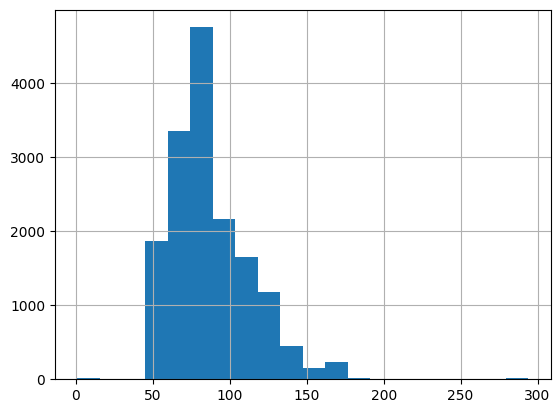

In [721]:
df['hp_kw_cleaned'].hist(bins = 20)

horsepower could be influenced by make model, type of fuel, and gearing type. Also directly related to displacement? Group by these and calculate mode

In [722]:
mode_hp = df[~(df['displacement_cleaned_cc'].isnull())]\
              .groupby(['make_model','body_cleaned_filled','displacement_cleaned_cc'])['hp_kw_cleaned']\
              .transform(lambda x: x.mode()[0] if list(x.mode()) != [] else np.nan)

In [723]:
df.loc[~(df['displacement_cleaned_cc'].isnull()),"hp_kw_cleaned"] = df.loc[~(df['displacement_cleaned_cc'].isnull()),"hp_kw_cleaned"].fillna(mode_hp)

In [724]:
mode_hp2 = df[~(df['displacement_cleaned_cc'].isnull())]\
              .groupby(['make_model','body_cleaned_filled'])['hp_kw_cleaned']\
              .transform(lambda x: x.mode()[0] if list(x.mode()) != [] else np.nan)

In [725]:
df["hp_kw_cleaned"] = df["hp_kw_cleaned"].fillna(mode_hp2)

In [726]:
mode_hp3 = df.groupby(['make_model','body_cleaned_filled'])['hp_kw_cleaned']\
              .transform(lambda x: x.mode()[0] if list(x.mode()) != [] else np.nan)

In [727]:
df["hp_kw_cleaned"] = df["hp_kw_cleaned"].fillna(mode_hp3)

In [728]:
mode_hp4 = df.groupby(['make_model'])['hp_kw_cleaned']\
              .transform(lambda x: x.mode()[0] if list(x.mode()) != [] else np.nan)

In [729]:
df["hp_kw_cleaned"] = df["hp_kw_cleaned"].fillna(mode_hp4)


In [730]:
df["hp_kw_cleaned"].isnull().sum()

np.int64(0)

In [731]:
df["hp_cleaned_filled"] = df["hp_kw_cleaned"]

## displacement_cleaned_cc

In [732]:
df['displacement_cleaned_cc'].value_counts(dropna= False)

displacement_cleaned_cc
1598.0     4761
999.0      2438
1398.0     1314
1399.0      749
1229.0      677
1956.0      670
1461.0      595
1490.0      559
NaN         496
1422.0      467
1197.0      353
898.0       351
1395.0      320
1968.0      301
1149.0      288
1618.0      212
1798.0      210
1498.0      196
1600.0      130
1248.0      110
1997.0      103
1364.0      102
1400.0       90
998.0        72
1500.0       50
2000.0       46
1000.0       40
1.0          36
1998.0       25
2480.0       20
1200.0       18
1984.0       18
899.0        11
1397.0       11
160.0         6
1499.0        5
929.0         5
1596.0        4
997.0         4
900.0         4
139.0         4
1396.0        3
1199.0        3
1599.0        3
995.0         2
1495.0        2
1589.0        2
1300.0        2
2.0           2
1369.0        1
15898.0       1
1350.0        1
1239.0        1
973.0         1
1696.0        1
1896.0        1
1584.0        1
996.0         1
1568.0        1
1686.0        1
1368.0        1


<Axes: >

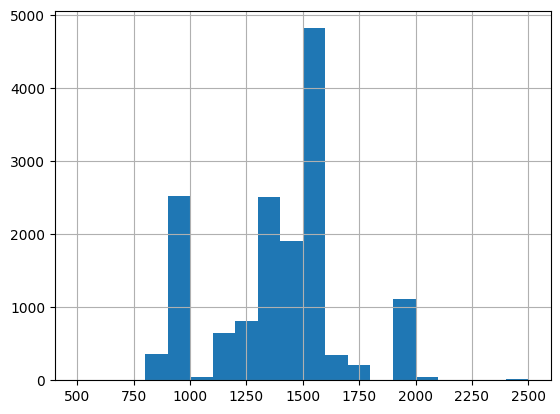

In [733]:
df['displacement_cleaned_cc'].hist(bins = 20, range = (500,2500))

In [734]:
mode_displacement = df.groupby(['make_model', 'type_cleaned_filled','hp_cleaned_filled'])['displacement_cleaned_cc'].transform(lambda x: x.mode()[0] if list(x.mode()) != [] else np.nan)
df['displacement_cleaned_filled'] = df['displacement_cleaned_cc'].fillna(mode_displacement)
df['displacement_cleaned_filled'].isna().sum()

np.int64(13)

In [735]:
mode_displacement1 = df.groupby(['make_model','body_cleaned_filled'])['displacement_cleaned_cc']\
              .transform(lambda x: x.mode()[0] if list(x.mode()) != [] else np.nan)
df['displacement_cleaned_filled'] = df['displacement_cleaned_filled'].fillna(mode_displacement1)
df['displacement_cleaned_filled'].isna().sum()

np.int64(0)

 ## cylinders_cleaned

In [736]:
df['cylinders_cleaned'].value_counts(dropna=False)

cylinders_cleaned
4.0    8105
NaN    5680
3.0    2104
5.0      22
6.0       3
8.0       2
2.0       2
1.0       1
Name: count, dtype: int64

In [737]:
mode_cylinders_cleaned = df.groupby(['make_model','body_cleaned_filled','displacement_cleaned_filled', 'weight_cleaned_kg'])['cylinders_cleaned'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
df['cylinders_cleaned_filled'] = df['cylinders_cleaned'].fillna(mode_cylinders_cleaned)
df['cylinders_cleaned_filled'].value_counts(dropna = False)

cylinders_cleaned_filled
4.0    8644
NaN    4824
3.0    2421
5.0      22
6.0       3
8.0       2
2.0       2
1.0       1
Name: count, dtype: int64

In [738]:
# groupby make_model only for remaining 21 NaNs
mode_cylinders_cleaned2 = df.groupby(['make_model', 'body_cleaned_filled','displacement_cleaned_filled'])['cylinders_cleaned'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
df['cylinders_cleaned_filled'] = df['cylinders_cleaned_filled'].fillna(mode_cylinders_cleaned2)
df['cylinders_cleaned_filled'].value_counts(dropna = False)

cylinders_cleaned_filled
4.0    12324
3.0     3412
NaN      153
5.0       22
6.0        3
8.0        2
2.0        2
1.0        1
Name: count, dtype: int64

In [739]:
# groupby 'make_model','body_cleaned_filled' only for remaining 153 NaNs
mode_cylinders_cleaned3 = df.groupby(['make_model','body_cleaned_filled'])['cylinders_cleaned'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
df['cylinders_cleaned_filled'] = df['cylinders_cleaned_filled'].fillna(mode_cylinders_cleaned3)
df['cylinders_cleaned_filled'].value_counts(dropna = False)

cylinders_cleaned_filled
4.0    12460
3.0     3422
5.0       22
NaN        7
6.0        3
8.0        2
2.0        2
1.0        1
Name: count, dtype: int64

In [740]:
# groupby 'body_cleaned_filled' only for remaining 7 NaNs
mode_cylinders_cleaned4 = df.groupby(['body_cleaned_filled'])['cylinders_cleaned'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
df['cylinders_cleaned_filled'] = df['cylinders_cleaned_filled'].fillna(mode_cylinders_cleaned4)
df['cylinders_cleaned_filled'].value_counts(dropna = False)

cylinders_cleaned_filled
4.0    12467
3.0     3422
5.0       22
6.0        3
8.0        2
2.0        2
1.0        1
Name: count, dtype: int64

## inspectionnew_cleaned

In [741]:
df.inspectionnew_cleaned.value_counts(dropna=False)

inspectionnew_cleaned
NaN    11987
Yes     3932
Name: count, dtype: int64

In [742]:
df['inspectionnew_cleaned_filled'] = df.inspectionnew_cleaned.fillna('No')
df['inspectionnew_cleaned_filled'].value_counts(dropna=False)

inspectionnew_cleaned_filled
No     11987
Yes     3932
Name: count, dtype: int64

In [743]:
df.drop('inspectionnew_cleaned', axis = 1, inplace = True)

## weight_cleaned_kg

In [744]:
df['weight_cleaned_kg'].isna().sum()

np.int64(6974)

In [745]:
# groupby factors affecting weight most obviously
mode_weight = df.groupby([
    'make_model',
    'body_cleaned_filled',
    'displacement_cleaned_filled'
])['weight_cleaned_kg'].transform(lambda x: x.mode()[0] if list(x.mode()) != [] else np.nan)

df['weight_cleaned_filled'] = df['weight_cleaned_kg'].fillna(mode_weight)
df['weight_cleaned_filled'].isna().sum()

np.int64(276)

In [746]:
# broaden the grouping to fill remaining 276 missing values
mode_weight2 = df.groupby([
    'body_cleaned_filled','make_model'
])['weight_cleaned_kg'].transform(lambda x: x.mode()[0] if list(x.mode()) != [] else np.nan)
df['weight_cleaned_filled'] = df['weight_cleaned_filled'].fillna(mode_weight2)
df['weight_cleaned_filled'].isna().sum()

np.int64(43)

In [747]:
# broaden the grouping to fill remaining 43 missing values
mode_weight3 = df.groupby([
    'make_model'
])['weight_cleaned_kg'].transform(lambda x: x.mode()[0] if list(x.mode()) != [] else np.nan)
df['weight_cleaned_filled'] = df['weight_cleaned_filled'].fillna(mode_weight3)
df['weight_cleaned_filled'].isna().sum()

np.int64(35)

In [748]:
# broaden the grouping to fill remaining 35 missing values
mode_weight4 = df.groupby([
    'body_cleaned_filled'
])['weight_cleaned_kg'].transform(lambda x: x.mode()[0] if list(x.mode()) != [] else np.nan)
df['weight_cleaned_filled'] = df['weight_cleaned_filled'].fillna(mode_weight4)
df['weight_cleaned_filled'].isna().sum()

np.int64(0)

## consumption city, country, comb

These three are closely related (comb is average of city and country), examine the pattern of missing values across the three columns to see if we can impute based on knowing the values of the other 2 columns (or else if we should only keep the combined consumption column)

In [749]:
# create boolena df indicating missing values
missing_combinations = df[['consumption_city_l_per_100km', 'consumption_comb_l_per_100km', 'consumption_country_l_per_100km']].isnull()
# count the occurances of each combination
missing_patterns = missing_combinations.groupby(['consumption_city_l_per_100km', 'consumption_comb_l_per_100km', 'consumption_country_l_per_100km']).size().reset_index(name='count')
missing_patterns

,consumption_city_l_per_100km,consumption_comb_l_per_100km,consumption_country_l_per_100km,count
0,False,False,False,12497
1,False,False,True,11
2,False,True,False,108
3,True,False,False,52
4,True,False,True,445
5,True,True,False,19
6,True,True,True,2787


In [750]:
# Impute missing values for consumption_comb_l_per_100km where I have both values for the other two by calculating their mean (108 missing values)
df['consumption_comb_l_per_100km'] = df['consumption_comb_l_per_100km'].fillna(
    (df['consumption_city_l_per_100km'] + df['consumption_country_l_per_100km']) / 2
)

Now I have gotten best use out of consumption_city and consumption_country columns, I can drop these, and impute the rest of the missing values from combined column by group-based imputation using medians

In [751]:
df.drop(['consumption_city_l_per_100km', 'consumption_country_l_per_100km'], axis = 1, inplace = True)

In [752]:
df['consumption_comb_l_per_100km'].value_counts(dropna= False)

consumption_comb_l_per_100km
NaN      2806
3.90      732
4.00      712
5.40      662
5.10      627
4.40      595
3.80      585
5.60      568
4.70      560
4.80      523
5.00      513
4.50      512
5.20      429
4.60      420
4.20      408
5.30      374
3.70      369
4.90      348
5.50      342
4.10      341
5.90      308
5.70      302
3.30      298
4.30      295
3.50      285
6.00      278
3.60      193
6.20      184
5.80      143
6.30      141
6.10      135
6.80      134
6.60      119
3.40      113
3.00       69
6.40       64
7.40       62
7.10       38
3.60       37
6.50       36
10.00      34
6.70       33
3.20       25
6.90       21
3.65       20
8.30       19
5.15       19
7.60       14
7.00        9
3.10        7
7.80        6
7.20        6
8.00        5
51.00       4
8.60        3
8.70        3
3.95        3
0.00        2
8.10        2
38.00       2
7.30        2
40.00       2
7.90        2
5.45        2
13.80       1
4.55        1
43.00       1
7.50        1
9.10        1
11.00

In [753]:
mode_comb = df.groupby(['co2emission_cleaned_filled','displacement_cleaned_filled','fuel_cleaned'])['consumption_comb_l_per_100km'].transform(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
df['consumption_comb_filled'] = df['consumption_comb_l_per_100km'].fillna(mode_comb)
df['consumption_comb_filled'].isna().sum()

np.int64(313)

In [754]:
mode_comb1 = df.groupby(['co2emission_cleaned_filled'])['consumption_comb_l_per_100km'].transform(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
df['consumption_comb_filled'] = df['consumption_comb_filled'].fillna(mode_comb1)
df['consumption_comb_filled'].isna().sum()

np.int64(5)

In [755]:
mode_comb2 = df.groupby(['displacement_cleaned_filled'])['consumption_comb_l_per_100km'].transform(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
df['consumption_comb_filled'] = df['consumption_comb_filled'].fillna(mode_comb2)
df['consumption_comb_filled'].isna().sum()

np.int64(0)

In [756]:
# Drop some columns that now have filled versions
df.drop(['nrofseats_cleaned', 'bodycolor_cleaned','nrofdoors_cleaned','painttype_cleaned','countryversion_cleaned','vat_cleaned',
         'interior_material','warranty_months','weight_cleaned_kg','consumption_comb_l_per_100km','cylinders_cleaned','displacement_cleaned_cc',
           'drivechain_cleaned', 'gears_cleaned','hp_kw_cleaned','year', 'registration_cleaned', 'type_cleaned', 'km_cleaned','emissionclass_cleaned','co2emission_cleaned_gco2/km','body_cleaned','type_cleaned',
         'previous_owners_cleaned','hp_kw_cleaned'], axis = 1, inplace = True)

## Simplify column names by dropping _cleaned_filled from them

In [757]:
df.columns = df.columns.str.replace(r'_cleaned_filled|_cleaned|_filled', '', regex = True)

In [758]:
list(df.columns)

['make_model',
 'price',
 'fuel',
 'particulate_filter',
 'multiple_fuel',
 'gearingtype',
 'air_conditioning',
 'armrest',
 'automatic_climate_control',
 'cruise_control',
 'electric_tailgate',
 'electrical_side_mirrors',
 'electrically_adjustable_seats',
 'electrically_heated_windshield',
 'heads-up_display',
 'heated_steering_wheel',
 'hill_holder',
 'keyless_central_door_lock',
 'leather_steering_wheel',
 'light_sensor',
 'lumbar_support',
 'multi-function_steering_wheel',
 'navigation_system',
 'panorama_roof',
 'park_distance_control',
 'parking_assist_system_camera',
 'parking_assist_system_self-steering',
 'parking_assist_system_sensors_front',
 'parking_assist_system_sensors_rear',
 'power_windows',
 'rain_sensor',
 'seat_heating',
 'seat_ventilation',
 'split_rear_seats',
 'start-stop_system',
 'tinted_windows',
 'bluetooth',
 'cd_player',
 'digital_radio',
 'hands-free_equipment',
 'mp3',
 'on-board_computer',
 'radio',
 'sound_system',
 'usb',
 'alloy_wheels',
 'catalytic_c

In [759]:
df.isna().sum().sort_index()

abs                                      0
adaptive_cruise_control                  0
adaptive_headlights                      0
age                                      0
air_conditioning                         0
alarm_system                             0
alloy_wheels                             0
armrest                                  0
automatic_climate_control                0
blind_spot_monitor                       0
bluetooth                                0
body                                     0
bodycolor                                0
catalytic_converter                      0
cd_player                                0
central_door_lock                        0
central_door_lock_with_remote_control    0
co2emission                              0
consumption_comb                         0
countryversion                           0
cruise_control                           0
cylinders                                0
daytime_running_lights                   0
digital_rad

In [760]:
# save the cleaned filled file as .csv file
df.to_csv('data/clean_filled_auto_scout.csv', index=False)

## Some extra notes

In [761]:
# Select only numeric columns
numeric_df = df.select_dtypes(include=[np.number])

# Compute the correlation matrix and get correlations with 'price', then sort
price_correlations = numeric_df.corr()['price'].sort_values()
price_correlations

age                                     -0.469011
km                                      -0.399105
previous_owners                         -0.246086
cd_player                               -0.084522
central_door_lock_with_remote_control   -0.072348
head_airbag                             -0.036500
fog_lights                              -0.027357
on-board_computer                       -0.023820
isofix                                  -0.010200
central_door_lock                       -0.008830
cylinders                               -0.004647
power_steering                          -0.000461
rear_airbag                              0.000989
split_rear_seats                         0.002250
mp3                                      0.008407
abs                                      0.013723
usb                                      0.016342
trailer_hitch                            0.018526
multiple_fuel                            0.025551
power_windows                            0.026105
